<a href="https://colab.research.google.com/github/lloydoad/disaster-tweet-classifier/blob/master/disaster_tweet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import string
import spacy
import nltk
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Exploring Dataset

In [38]:
train_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/train.csv'
test_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/test.csv'
train = pd.read_csv(train_url_path, error_bad_lines=False)
test = pd.read_csv(test_url_path, error_bad_lines=False)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [39]:
train_length, test_length, feature_count = train.shape[0], test.shape[0], test.shape[1]
print('Number of features: ', feature_count)
print('Number of instances in training set: ', train_length)
print('Number of instances in test set: ', test_length)
print('Total number of instances:', train_length + test_length)

Number of features:  3
Number of instances in training set:  7613
Number of instances in test set:  3263
Total number of instances: 10876


In [40]:
print('First 10 train datapoints')
train.head(10)

First 10 train datapoints


,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,NaN,NaN,There's an emergency evacuation happening now ...,1
9,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [41]:
print('First 10 test datapoints')
test.head(10)

First 10 test datapoints


,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,NaN,NaN,We're shaking...It's an earthquake
6,NaN,NaN,They'd probably still show more life than Arse...
7,NaN,NaN,Hey! How are you?
8,NaN,NaN,What a nice hat?
9,NaN,NaN,Fuck off!


In [42]:
train_missing_keywords, test_missing_keywords = train.keyword.isna().sum(), test.keyword.isna().sum()
train_missing_location, test_missing_location = train.location.isna().sum(), test.location.isna().sum()
print('Number of missing keywords: Train {}, Test {}'.format(train_missing_keywords, test_missing_keywords))
print('Number of missing location: Train {}, Test {}'.format(train_missing_location, test_missing_location))

Number of missing keywords: Train 61, Test 26
Number of missing location: Train 2533, Test 1105


In [43]:
for dataFrame in [train, test]:
  dataFrame.keyword.fillna('no_keywords', inplace=True)
  dataFrame.location.fillna('no_location', inplace=True)

Looking at the number of missing values for keywords and location for both training and test set, we see that there are more missing locations (**~33%**) than keywords (**~0.8%**)
Unavailable keyword or location features are explicitly stated. 

In [45]:
train.sample(20)

,keyword,location,text,target
7435,wounds,Charlotte,Gunshot wound #9 is in the bicep. The only one...,1
4934,mayhem,no_location,Asbury Park shooting reported http://t.co/dADZ...,1
4404,hijacking,France,#hot Funtenna: hijacking computers to send da...,0
1615,collapse,In the clouds...,@BehindAShield @Wars_Goddess Sweet Lord. (I c...,0
1979,cyclone,no_location,WFP - WFP Delivers Food To 165000 Bangladesh F...,1
3171,emergency%20plan,"Alexandria, VA, USA",See Aug 4 2015 PoconoRecord @EmergencyMgtMag -...,1
4984,military,no_location,@kiranahmedd US military and Nato are fighting...,1
7534,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1
6530,survive,no_location,Suicide of a Superpower : Will America Survive...,0
4251,heat%20wave,"Greenfield, Massachusetts",Many thx for share and your comment Alex Light...,0


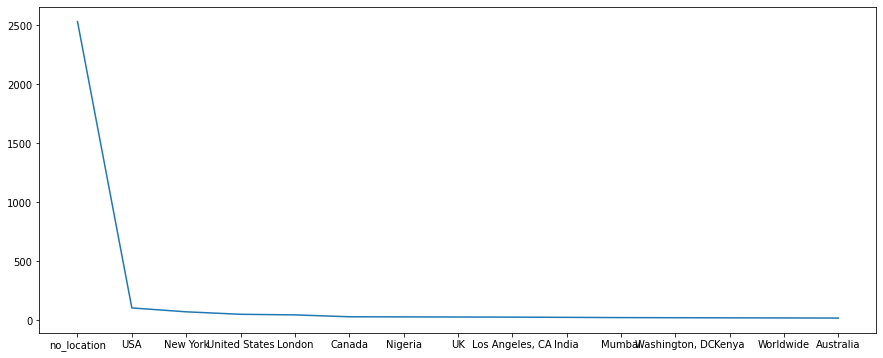

In [46]:
top_15_locations = train.groupby(['location']).count().text.sort_values(ascending=False)[:15]
figure(figsize=(15,6))
plt.plot(top_15_locations)
plt.show()

The frequency per unique location is very low. 
There's also multiple locations with different representations that mean the same thing; for example United States and USA.
Location may not be an important factor in classifying texts due to it being varied and 1/3 of the datapoints not having any location feature at all.

# Pre-Processing

First stage of processing for NLP is cleaning the tweet to take out stop words, http links, and extra characters like punctuations or trailing spaces.

In [47]:
nlp = spacy.load('en')
sp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [77]:
spacy_stopwords = nlp.Defaults.stop_words
nltk_stopwords = stopwords.words('english')
print('Number of stop words for nltk: ', len(nltk_stopwords))
print('Number of stop words for spacy: ', len(spacy_stopwords))

Number of stop words for nltk:  179
Number of stop words for spacy:  326


In [92]:
def clean(tweet, stop_words='nltk'):
  # Remove link portion of attachments in tweet
  tweet = re.sub('https?:\/\/t.co\/[A-Za-z0-9]*', '', tweet)
  
  # Remove stop words
  chosen_stop_words = nltk_stopwords if stopwords == 'nltk' else spacy_stopwords
  tweet = [word for word in word_tokenize(tweet) if not word.lower() in chosen_stop_words]
  tweet = ' '.join(tweet)

  # # Remove puntuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # # Remove extra space
  tweet = re.sub("\s+", ' ', tweet)

  return tweet

In [88]:
test_tweet = train.sample(1).values[0,2]
print(
    'Cleaning example\nOriginal Tweet:', test_tweet, 
    'Tweet cleaned with NLTK', clean(test_tweet),
    'Tweet cleaned with Spacy', clean(test_tweet, stop_words='spacy'),
    sep='\n'
    )

Cleaning example
Original Tweet:
You Are Invited to The Expo Explosion Summer Event 2015! 
WHEN: August 14th Friday 2015
WHERE: Ben E Keith... http://t.co/yh4R7Ug21a
Tweet cleaned with NLTK
Invited Expo Explosion Summer Event 2015 August 14th Friday 2015 Ben E Keith 
Tweet cleaned with Spacy
Invited Expo Explosion Summer Event 2015 August 14th Friday 2015 Ben E Keith 


In [89]:
train['nltk_text'] = train.text.apply(lambda x:clean(x))
train['spcy_text'] = train.text.apply(lambda x:clean(x, stop_words='spacy'))

In [91]:
train.sample(5)

,keyword,location,text,target,nltk_text,spcy_text
7414,wounded,"Suva, Fiji Islands.",GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,GENERAL AUDIENCE Wounded Families ZENIT World ...,GENERAL AUDIENCE Wounded Families ZENIT World ...
4777,lightning,"Waverly, IA",'When you walk away\nNothing more to say\nSee ...,0,When walk away lightning eyes Û÷em running li...,When walk away lightning eyes Û÷em running li...
2104,death,"Kensington, MD",http://t.co/lMA39ZRWoY There is a way which se...,1,way seemeth right unto man end thereof ways de...,way seemeth right unto man end thereof ways de...
7056,upheaval,Oregon,A look at state actions a year after Ferguson'...,0,look state actions year Ferguson upheaval,look state actions year Ferguson upheaval
2790,disaster,no_location,My first staining attempt was a disaster https...,0,staining attempt disaster,staining attempt disaster
